In [ ]:
# 共10000行
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 保留需要的列并保存到cleaned_data
path = "./USvideos.csv"
columns = ['title', 'description', 'category_id', 'tags']
data = pd.read_csv(path, usecols=columns, nrows=10000)

data['description'] = data['description'].fillna('')
data['tags'] = data['tags'].fillna('')
data['text'] = data['title'] + ' ' + data['description']
data = data.dropna(subset=['category_id'])
print(data)

cleaned_data = data[['text', 'category_id', 'tags']].copy()
cleaned_data.to_csv("./cleaned_data.csv", index=False)

                                                  title  category_id  \
0                    WE WANT TO TALK ABOUT OUR MARRIAGE           22   
1     The Trump Presidency: Last Week Tonight with J...           24   
2     Racist Superman | Rudy Mancuso, King Bach & Le...           23   
3                      Nickelback Lyrics: Real or Fake?           24   
4                              I Dare You: GOING BALD!?           24   
...                                                 ...          ...   
9995                                       2016 vs 2017           23   
9996          Dude Perfect Face Off | What's In The Box           17   
9997                              MST3K (2017) Yule Log           23   
9998  TITANIC TRANSFORMATION! THE ROSE LOOK FEAT. GU...           26   
9999    Making new sounds using artificial intelligence           10   

                                                   tags  \
0                                       SHANtell martin   
1     last week t

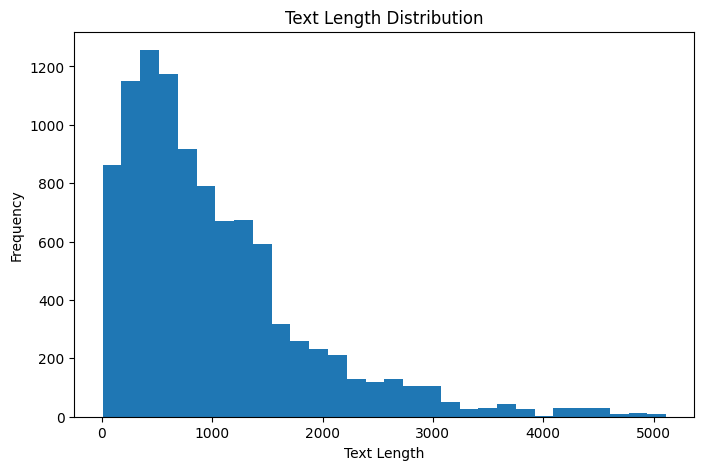

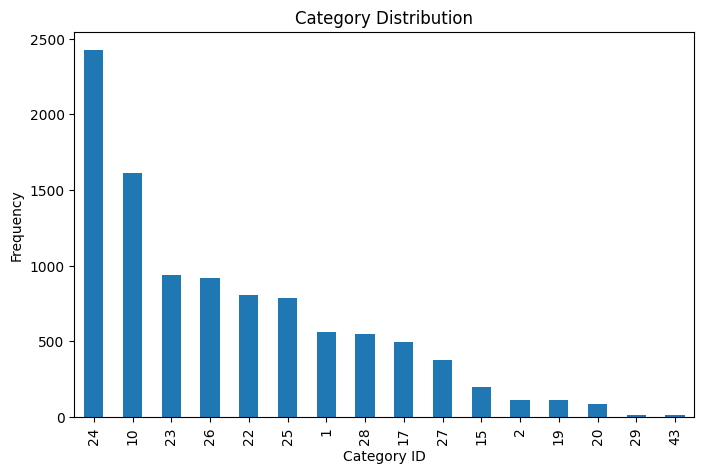

In [3]:
import matplotlib.pyplot as plt

cleaned_data['text_length'] = cleaned_data['text'].apply(len)

category_counts = cleaned_data['category_id'].value_counts()

plt.figure(figsize=(8, 5))
plt.hist(cleaned_data['text_length'], bins=30)
plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 5))
category_counts.plot(kind='bar')
plt.title("Category Distribution")
plt.xlabel("Category ID")
plt.ylabel("Frequency")
plt.show()

In [4]:
from sklearn.model_selection import train_test_split

# 80%/20%
train_data, test_data = train_test_split(cleaned_data, test_size=0.2, random_state=0)
print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

train_data.to_csv("./train_data.csv", index=False)
test_data.to_csv("./test_data.csv", index=False)

# 是否能反映全集
train_category_counts = train_data['category_id'].value_counts(normalize=True)
test_category_counts = test_data['category_id'].value_counts(normalize=True)

train_data['text_length'] = train_data['text'].apply(len)
test_data['text_length'] = test_data['text'].apply(len)

print("Training Set Category Distribution (Normalized):")
print(train_category_counts)

print("\nTest Set Category Distribution (Normalized):")
print(test_category_counts)

print("\nTraining Set Text:")
print(train_data['text_length'].describe())

print("\nTest Set Text:")
print(test_data['text_length'].describe())


Training set size: 8000
Test set size: 2000
Training Set Category Distribution (Normalized):
category_id
24    0.244250
10    0.161375
23    0.094875
26    0.091250
22    0.079000
25    0.078125
1     0.056000
28    0.055750
17    0.049375
27    0.036000
15    0.020500
2     0.011750
19    0.010500
20    0.008625
29    0.001625
43    0.001000
Name: proportion, dtype: float64

Test Set Category Distribution (Normalized):
category_id
24    0.2350
10    0.1625
26    0.0930
23    0.0895
22    0.0860
25    0.0820
1     0.0580
28    0.0515
17    0.0490
27    0.0440
15    0.0185
19    0.0125
2     0.0085
20    0.0080
43    0.0015
29    0.0005
Name: proportion, dtype: float64

Training Set Text:
count    8000.000000
mean     1015.709250
std       842.020762
min         7.000000
25%       416.000000
50%       785.000000
75%      1370.000000
max      5114.000000
Name: text_length, dtype: float64

Test Set Text:
count    2000.000000
mean     1029.237000
std       873.175987
min         7.000000
2

In [5]:
cleaned_data['tags'] = cleaned_data['tags'].str.replace('"', '')
cleaned_data['tags'] = cleaned_data['tags'].str.lower()
cleaned_data['tag_list'] = cleaned_data['tags'].apply(lambda x: x.split('|'))

# 标签全集
unique_tags = set(tag for tags in cleaned_data['tag_list'] for tag in tags if tag.strip())
unique_tags = sorted(unique_tags)

# 标签到索引映射
tag_to_index = {tag: i for i, tag in enumerate(unique_tags)}

def create_label_vector(tag_list, tag_to_index, n_tags):
    label_vector = [0] * n_tags
    for tag in tag_list:
        tag = tag.strip()
        if tag in tag_to_index:
            label_vector[tag_to_index[tag]] = 1
    return label_vector

n_tags = len(unique_tags)
cleaned_data['label_vector'] = cleaned_data['tag_list'].apply(
    lambda tags: create_label_vector(tags, tag_to_index, n_tags)
)

label_matrix = np.array(cleaned_data['label_vector'].tolist())

print(f"Total unique tags: {n_tags}")
print(f"Sample label vector (first 5 rows):")
print(label_matrix[:5])


Total unique tags: 20739
Sample label vector (first 5 rows):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [6]:
n_samples = len(cleaned_data)
n_tags = len(unique_tags)

label_matrix_dense = np.zeros((n_samples, n_tags), dtype=int)

for i, tags in enumerate(cleaned_data['tag_list']):
    for tag in tags:
        tag = tag.strip()
        if tag in tag_to_index:
            label_matrix_dense[i, tag_to_index[tag]] = 1

print(f"Total unique tags: {n_tags}")
print(f"Dense matrix shape: {label_matrix_dense.shape}")
print(f"Non-zero entries: {np.sum(label_matrix_dense)}")

Total unique tags: 20739
Dense matrix shape: (10000, 20739)
Non-zero entries: 188328


Number of unique tags: 20739
Average tags per sample: 18.83
Matrix density: 0.000908


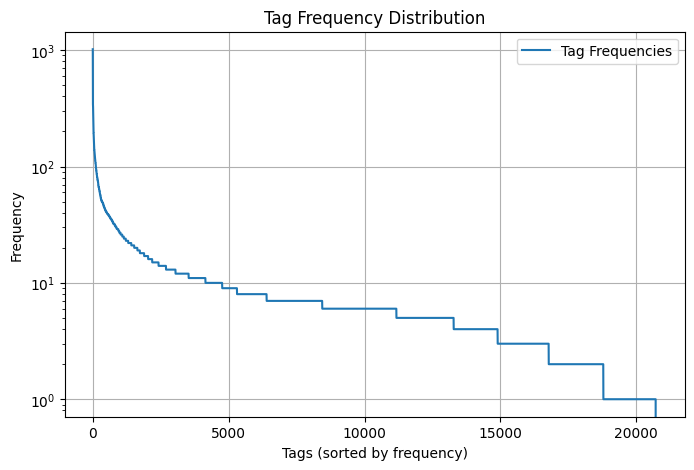

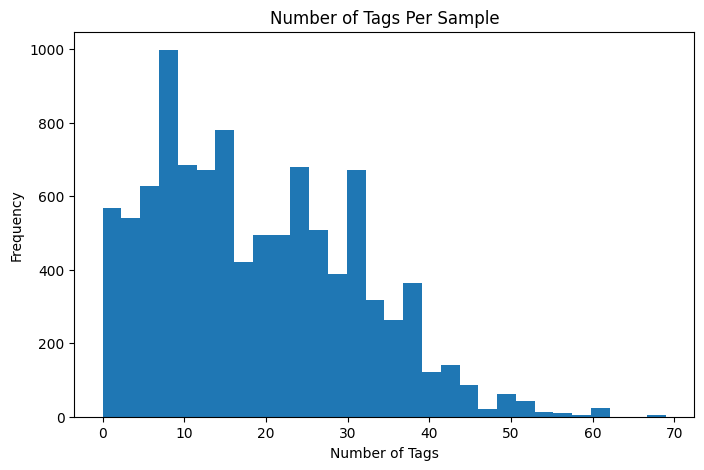

In [7]:
import matplotlib.pyplot as plt
import numpy as np

sample_tag_counts = np.sum(label_matrix_dense, axis=1)

matrix_density = np.sum(label_matrix_dense) / (n_samples * n_tags)

print(f"Number of unique tags: {n_tags}")
print(f"Average tags per sample: {sample_tag_counts.mean():.2f}")
print(f"Matrix density: {matrix_density:.6f}")

tag_frequencies = np.sum(label_matrix_dense, axis=0)

sorted_frequencies = np.sort(tag_frequencies)[::-1]
cumulative_frequencies = np.cumsum(sorted_frequencies) / sorted_frequencies.sum()

# 频率：长尾分布曲线
plt.figure(figsize=(8, 5))
plt.plot(sorted_frequencies, linestyle='-', label='Tag Frequencies')
plt.title("Tag Frequency Distribution")
plt.xlabel("Tags (sorted by frequency)")
plt.ylabel("Frequency")
plt.yscale('log')  # 对数缩放
plt.grid()
plt.legend()
plt.show()

# 视频标签数量分布
plt.figure(figsize=(8, 5))
plt.hist(sample_tag_counts, bins=30)
plt.title("Number of Tags Per Sample")
plt.xlabel("Number of Tags")
plt.ylabel("Frequency")
plt.show()


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

# Text: TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000) # 限制feature数量
text_features = vectorizer.fit_transform(cleaned_data['text'])

# Category: One-Hot
encoder = OneHotEncoder(handle_unknown='ignore')
category_features = encoder.fit_transform(cleaned_data[['category_id']])
category_features *= (text_features.shape[1] / category_features.shape[1]) * 0.5 # 2:1的权重

combined_features = hstack([text_features, category_features])

print(f"Text features shape: {text_features.shape}")
print(f"Category features shape: {category_features.shape}")
print(f"Combined features shape: {combined_features.shape}")

Text features shape: (10000, 1000)
Category features shape: (10000, 16)
Combined features shape: (10000, 1016)


In [10]:
train_indices = train_data.index
test_indices = test_data.index

X_train = combined_features[train_indices, :]
X_test = combined_features[test_indices, :]

y_train = label_matrix_dense[train_indices, :]
y_test = label_matrix_dense[test_indices, :]

valid_labels = []
for i in range(y_train.shape[1]):
    unique_values = np.unique(y_train[:, i])
    if len(unique_values) > 1:  # 标签列需要至少两个类别
        valid_labels.append(i)

# 有效标签列
y_train_valid = y_train[:, valid_labels]
y_test_valid = y_test[:, valid_labels]

# 证明不会有显著过滤效果
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"Valid training labels shape: {y_train_valid.shape}")
print(f"Valid Test labels shape: {y_test_valid.shape}")

y_train = y_train_valid
y_test = y_test_valid

Training features shape: (8000, 1016)
Test features shape: (2000, 1016)
Training labels shape: (8000, 20739)
Test labels shape: (2000, 20739)
Valid training labels shape: (8000, 20159)
Valid Test labels shape: (2000, 20159)


In [11]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from tqdm import tqdm

def train_naive_bayes_with_progress(X_train, y_train, chunk_size=100):
    n_labels = y_train.shape[1]
    models = {}

    with tqdm(total=n_labels, desc="Training Naive Bayes") as pbar:
        for i in range(0, n_labels, chunk_size):
            end = min(i + chunk_size, n_labels)
            y_chunk = y_train[:, i:end]

            for j in range(y_chunk.shape[1]):
                label_index = i + j
                y_single = y_chunk[:, j]

                model = MultinomialNB()
                model.fit(X_train, y_single)
                models[label_index] = model

                pbar.update(1)

    return models

nb_models = train_naive_bayes_with_progress(X_train, y_train, chunk_size=100)


Training Naive Bayes: 100%|██████████| 20159/20159 [01:11<00:00, 283.47it/s]


In [12]:
# Logistic Regression
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

def train_logistic_regression_with_progress(X_train, y_train, chunk_size=100):
    n_labels = y_train.shape[1]
    models = {}
    skipped_labels = []

    # 总的训练量是14778,即unique labels
    with tqdm(total=n_labels, desc="Training Logistic Regression") as pbar:
        for i in range(0, n_labels, chunk_size):
            end = min(i + chunk_size, n_labels)
            y_chunk = y_train[:, i:end]

            for j in range(y_chunk.shape[1]):
                label_index = i + j
                y_single = y_chunk[:, j]

                model = LogisticRegression(max_iter=1000, random_state=0)
                model.fit(X_train, y_single)
                models[label_index] = model

                pbar.update(1)

    return models

log_reg_models = train_logistic_regression_with_progress(X_train, y_train, chunk_size=100)

Training Logistic Regression: 100%|██████████| 20159/20159 [16:48<00:00, 19.99it/s]


In [13]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

def train_random_forest_with_progress(X_train, y_train, chunk_size=100):
    n_labels = y_train.shape[1]
    models = {}

    with tqdm(total=n_labels, desc="Training Random Forest") as pbar:
        for i in range(0, n_labels, chunk_size):
            end = min(i + chunk_size, n_labels)
            y_chunk = y_train[:, i:end]

            for j in range(y_chunk.shape[1]):
                label_index = i + j
                y_single = y_chunk[:, j]

                model = RandomForestClassifier(n_estimators=15, max_depth=8, random_state=0)
                model.fit(X_train, y_single)
                models[label_index] = model

                pbar.update(1)

    return models

rf_models = train_random_forest_with_progress(X_train, y_train, chunk_size=1000)


Training Random Forest: 100%|██████████| 20159/20159 [15:22<00:00, 21.85it/s]


In [14]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

def train_knn_with_progress(X_train, y_train, chunk_size=100):
    n_labels = y_train.shape[1]
    models = {}

    with tqdm(total=n_labels, desc="Training KNN") as pbar:
        for i in range(0, n_labels, chunk_size):
            end = min(i + chunk_size, n_labels)
            y_chunk = y_train[:, i:end]

            for j in range(y_chunk.shape[1]):
                label_index = i + j
                y_single = y_chunk[:, j]

                model = KNeighborsClassifier(n_neighbors=5, metric='cosine')
                model.fit(X_train, y_single)
                models[label_index] = model

                pbar.update(1)

    return models

knn_models = train_knn_with_progress(X_train, y_train, chunk_size=100)

Training KNN: 100%|██████████| 20159/20159 [01:12<00:00, 279.67it/s]


In [15]:
from sklearn.metrics import hamming_loss, accuracy_score, precision_recall_fscore_support
import numpy as np

def evaluate_models(models, X_test, y_test, model_name="Model"):
    n_samples, n_labels = y_test.shape
    y_pred = np.zeros_like(y_test)

    for label_index, model in models.items():
        y_pred[:, label_index] = model.predict(X_test)

    hamming = hamming_loss(y_test, y_pred)
    subset_accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')

    print(f"Evaluation results for {model_name}:")
    print(f"Hamming Loss: {hamming:.4f}")
    print(f"Subset Accuracy: {subset_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("-" * 40)

    return {
        "hamming_loss": hamming, # 1 - 预测错误标签占比
        "subset_accuracy": subset_accuracy, # 完全预测正确向量数.对tags而言是不完全现实的
        "precision": precision, # 预测为正类的标签中正确的占比
        "recall": recall, # 对所有正类标签的预测覆盖程度
        "f1_score": f1, # Precision 和 Recall 的调和平均
    }

nb_metrics = evaluate_models(nb_models, X_test, y_test, model_name="Naive Bayes")
log_reg_metrics = evaluate_models(log_reg_models, X_test, y_test, model_name="Logistic Regression")
rf_metrics = evaluate_models(rf_models, X_test, y_test, model_name="Random Forest")
# knn_metrics = evaluate_models(knn_models, X_test, y_test, model_name="KNN")

all_metrics = {
    "Logistic Regression": log_reg_metrics,
    "Random Forest": rf_metrics,
    # "KNN": knn_metrics,
    "Naive Bayes": nb_metrics,
}

Evaluation results for Naive Bayes:
Hamming Loss: 0.0528
Subset Accuracy: 0.0015
Precision: 0.0123
Recall: 0.7211
F1-Score: 0.0242
----------------------------------------
Evaluation results for Logistic Regression:
Hamming Loss: 0.0007
Subset Accuracy: 0.0315
Precision: 0.9704
Recall: 0.1830
F1-Score: 0.3080
----------------------------------------
Evaluation results for Random Forest:
Hamming Loss: 0.0001
Subset Accuracy: 0.4310
Precision: 0.9925
Recall: 0.8921
F1-Score: 0.9396
----------------------------------------


In [16]:
from sklearn.metrics import hamming_loss, accuracy_score, precision_recall_fscore_support
import numpy as np

def evaluate_knn(knn_model, X_train, y_train, X_test, y_test):
    n_samples, n_labels = y_test.shape
    y_pred = np.zeros_like(y_test)

    # 逐样本预测
    for i in range(n_samples):
        # 获取最近邻的索引和距离
        distances, indices = knn_model.kneighbors(X_test[i].reshape(1, -1))
        # 聚合邻居的标签
        neighbor_labels = y_train[indices[0]]
        y_pred[i] = np.rint(neighbor_labels.mean(axis=0))

    hamming = hamming_loss(y_test, y_pred)
    subset_accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')

    print("Evaluation results for KNN:")
    print(f"Hamming Loss: {hamming:.4f}")
    print(f"Subset Accuracy: {subset_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("-" * 40)

    return {
        "hamming_loss": hamming,
        "subset_accuracy": subset_accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
    }

knn_metrics = evaluate_knn(knn_models[0], X_train, y_train, X_test, y_test)


Evaluation results for KNN:
Hamming Loss: 0.0002
Subset Accuracy: 0.7780
Precision: 0.8882
Recall: 0.8523
F1-Score: 0.8699
----------------------------------------


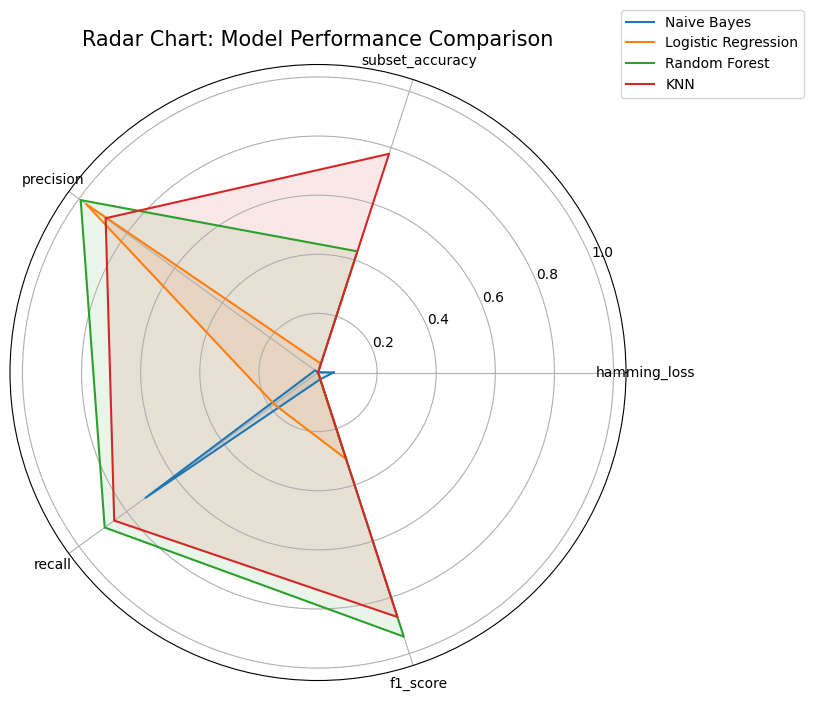

In [ ]:
from math import pi

labels = metrics
num_vars = len(labels)

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

for model, model_metrics in all_metrics.items():
    values = [model_metrics[metric] for metric in labels]
    values += values[:1]
    ax.plot(angles, values, label=model)
    ax.fill(angles, values, alpha=0.1)

ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.title("Radar Chart: Model Performance Comparison", size=15)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()
